# XG Boost Regressor

## Importing the libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [2]:
# pyspark_df = spark.table("sd_bdc_demo.xgboost_regression.1_salesforce_updated_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [3]:
# Load csv file
df = pd.read_csv("1_salesforce_updated_data/1_salesforce_updated_data.csv")

In [4]:
print(df)

    Sales_Order                 Stage  Amount  Probability    Sales_Person  \
0          5708           Closed Lost  255000            0  Alex Rodriguez   
1          5709       Decision Makers  315000           70   Sarah Johnson   
2          5710  Proposal/Price Quote  275000           65   Michael Chang   
3          5711            Closed Won  135000          100     Emma Wilson   
4          5712    Negotiation/Review  325000           85  David Martinez   
..          ...                   ...     ...          ...             ...   
91         5799   Perception Analysis  475000           25  Alex Rodriguez   
92         5800     Value Proposition  115000           40   Sarah Johnson   
93         5801         Qualification   95000           20   Michael Chang   
94         5802            Closed Won   68000          100     Emma Wilson   
95         5803        Needs Analysis  185000           35  David Martinez   

      Company_Industry              Contact_Title          Type

In [5]:
print(df.shape)

(96, 11)


In [6]:
print(df.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sales_Order       96 non-null     int64 
 1   Stage             96 non-null     object
 2   Amount            96 non-null     int64 
 3   Probability       96 non-null     int64 
 4   Sales_Person      96 non-null     object
 5   Company_Industry  96 non-null     object
 6   Contact_Title     96 non-null     object
 7   Type              96 non-null     object
 8   Lead_Source       96 non-null     object
 9   State             96 non-null     object
 10  days_to_close     96 non-null     int64 
dtypes: int64(4), object(7)
memory usage: 8.4+ KB
None


## Encoding categorical data

### Encoding the Independent Variable

In [8]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
categorical_cols = [
    'Sales_Person',
    'Company_Industry',
    'Contact_Title',
    'Type',
    'Lead_Source',
    'State'
]

# Save encoder for later use
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  


In [9]:
print(df_encoded.head())

   Sales_Order                 Stage  Amount  Probability  Sales_Person  \
0         5708           Closed Lost  255000            0             0   
1         5709       Decision Makers  315000           70             4   
2         5710  Proposal/Price Quote  275000           65             3   
3         5711            Closed Won  135000          100             2   
4         5712    Negotiation/Review  325000           85             1   

   Company_Industry  Contact_Title  Type  Lead_Source  State  days_to_close  
0                12             29     0            5     42             45  
1                11             20     0           14     23             97  
2                 8              8     0            6     39            117  
3                19             28     0           16     31             36  
4                15             41     0           10     29             92  


In [10]:
print(df_encoded.shape)

(96, 11)


In [11]:
print(df_encoded.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


## Split two Data Frame for Independent Features & Dependent Columns

In [12]:
df_independent = df_encoded.drop(columns=['Probability'])
X = df_independent
df_dependent = df_encoded[['Probability']]
y = df_dependent

In [13]:
print(df_independent.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
0         5708           Closed Lost  255000             0                12   
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
3         5711            Closed Won  135000             2                19   
4         5712    Negotiation/Review  325000             1                15   

   Contact_Title  Type  Lead_Source  State  days_to_close  
0             29     0            5     42             45  
1             20     0           14     23             97  
2              8     0            6     39            117  
3             28     0           16     31             36  
4             41     0           10     29             92  


In [14]:
print(df_independent.shape)

(96, 10)


In [15]:
print(df_dependent.head())

   Probability
0            0
1           70
2           65
3          100
4           85


In [16]:
print(df_dependent.shape)

(96, 1)


## Splitting the dataset into the Training set and Test set (`Closed Won` & `Closed Lost` = `train`)

In [17]:
# Define which rows go into train and test based on 'Stage'
is_train = df_encoded['Stage'].isin(['Closed Won', 'Closed Lost'])

# Split X
X_train = X[is_train] 
X_test = X[~is_train]

# Split y
y_train = y[is_train]
y_test = y[~is_train]  


In [18]:
print(X_train.head())

    Sales_Order        Stage  Amount  Sales_Person  Company_Industry  \
0          5708  Closed Lost  255000             0                12   
3          5711   Closed Won  135000             2                19   
8          5716   Closed Won  235000             2                12   
12         5720   Closed Won  225000             2                 8   
17         5725   Closed Won  175000             2                12   

    Contact_Title  Type  Lead_Source  State  days_to_close  
0              29     0            5     42             45  
3              28     0           16     31             36  
8               4     2            5     38             36  
12             11     2            4     24             38  
17             48     2            5     21             40  


In [19]:
print(X_train.shape)

(25, 10)


In [20]:
print(X_test.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
4         5712    Negotiation/Review  325000             1                15   
5         5713   Perception Analysis  345000             0                23   
6         5714     Value Proposition  195000             4                 6   

   Contact_Title  Type  Lead_Source  State  days_to_close  
1             20     0           14     23             97  
2              8     0            6     39            117  
4             41     0           10     29             92  
5             32     0           14     33            204  
6             20     0            2     41            158  


In [21]:
print(X_test.shape)

(71, 10)


In [22]:
print(y_train.head())

    Probability
0             0
3           100
8           100
12          100
17          100


In [23]:
print(y_train.shape)

(25, 1)


In [24]:
print(y_test.head())

   Probability
1           70
2           65
4           85
5           20
6           45


In [25]:
print(y_test.shape)

(71, 1)


## Feature Scaling
- As this is a tree based model, no need to do feature scaling

## Removing `Sales_Order` & `Stage` in `X_train` & `X_test`

In [26]:
X_train_new = X_train.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [27]:
print(X_train_new.head())

    Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
0   255000                12             29     0            5     42   
3   135000                19             28     0           16     31   
8   235000                12              4     2            5     38   
12  225000                 8             11     2            4     24   
17  175000                12             48     2            5     21   

    days_to_close  
0              45  
3              36  
8              36  
12             38  
17             40  


In [28]:
print(X_train_new.shape)

(25, 7)


In [29]:
X_test_new = X_test.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [30]:
print(X_test_new.head())

   Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
1  315000                11             20     0           14     23   
2  275000                 8              8     0            6     39   
4  325000                15             41     0           10     29   
5  345000                23             32     0           14     33   
6  195000                 6             20     0            2     41   

   days_to_close  
1             97  
2            117  
4             92  
5            204  
6            158  


In [31]:
print(X_test_new.shape)

(71, 7)


## Training the Model

In [32]:
from xgboost import XGBRegressor

# Initialize the model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)


### RFE

In [33]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=xgb_model, n_features_to_select=5)
rfe.fit(X_train_new, y_train)

# selected features after RFE
selected_features = X_train_new.columns[rfe.support_]
print(selected_features)

Index(['Amount', 'Contact_Title', 'Lead_Source', 'State', 'days_to_close'], dtype='object')


In [34]:
# take only selected columns for both X_train_new & X_test_new
X_train_new = X_train_new[selected_features]
X_test_new = X_test_new[selected_features]
xgb_model_train = xgb_model.fit(X_train_new, y_train.values.ravel())


## Prediction

In [35]:
y_pred = xgb_model.predict(X_test_new)

In [36]:
print(y_pred)

[ 52.455616   17.717596   53.618717   51.469036   -1.0227274   3.4656625
  17.915543   30.059286   39.91373    27.465069   64.96093    46.929306
  48.74339    17.248314   13.704345   52.909737   55.25483    40.4807
  -1.876173   18.265318   57.807613   10.661234   27.491089   60.272457
  64.63151    48.517662   30.293076   48.61091    27.464687   60.037437
  57.725945   49.82789    59.559536   44.688652   27.383394   33.699482
  53.498302   48.873123   39.806038   29.58515    64.949196    0.8756924
  24.704447   14.053696   51.828045   53.618717   48.43194    30.059286
  54.178394  100.09572   101.78862    88.82907    49.177296   13.704345
  24.796244   73.24305    52.64015    99.88471    53.62326    41.55799
   6.9072437  52.57603   101.29233    10.6274805  87.22117    53.964405
  26.940435   17.915543   52.032978   -5.8286366  49.710953 ]


### Saving the output as new table

In [37]:
sales_order = X_test['Sales_Order'].values
stage = X_test['Stage'].values

In [38]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (71,)
stage shape: (71,)
y_test shape: (71, 1)
y_pred shape: (71,)


In [39]:
print(y_test)

    Probability
1            70
2            65
4            85
5            20
6            45
..          ...
90           85
91           25
92           40
93           20
95           35

[71 rows x 1 columns]


In [40]:
# Flatten y_test to 1D
y_test = y_test.values.ravel()

In [41]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (71,)
stage shape: (71,)
y_test shape: (71,)
y_pred shape: (71,)


In [42]:
print(y_test)

[70 65 85 20 45 25 30 75 60 85 25 40 30 30 70 65 80 20 45 25 35 75 60 90
 20 40 30 35 70 65 80 15 45 25 30 75 60 85 20 40 30 35 70 65 85 15 45 25
 30 30 60 20 80 40 25 15 70 90 65 75 20 35 45 30 70 60 85 25 40 20 35]


In [43]:
print(y_pred)

[ 52.455616   17.717596   53.618717   51.469036   -1.0227274   3.4656625
  17.915543   30.059286   39.91373    27.465069   64.96093    46.929306
  48.74339    17.248314   13.704345   52.909737   55.25483    40.4807
  -1.876173   18.265318   57.807613   10.661234   27.491089   60.272457
  64.63151    48.517662   30.293076   48.61091    27.464687   60.037437
  57.725945   49.82789    59.559536   44.688652   27.383394   33.699482
  53.498302   48.873123   39.806038   29.58515    64.949196    0.8756924
  24.704447   14.053696   51.828045   53.618717   48.43194    30.059286
  54.178394  100.09572   101.78862    88.82907    49.177296   13.704345
  24.796244   73.24305    52.64015    99.88471    53.62326    41.55799
   6.9072437  52.57603   101.29233    10.6274805  87.22117    53.964405
  26.940435   17.915543   52.032978   -5.8286366  49.710953 ]


In [44]:
results_df = pd.DataFrame({
    'sales_order': sales_order,
    'stage': stage,
    'Actual': y_test,
    'Predicted': y_pred
})


In [45]:
# Create the folder if it doesn't exist
os.makedirs("2_1_salesforce_xgboost_prediction_data", exist_ok=True)

# Save the Excel file inside the folder
results_df.to_csv("2_1_salesforce_xgboost_prediction_data/2_1_salesforce_xgboost_prediction_data.csv", index=False)


In [46]:
# spark_df = spark.createDataFrame(results_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.2_1_salesforce_xgboost_prediction_data")

## Accuracy

In [47]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print("r2:\n", r2_score(y_test, y_pred))
print("MAE:\n", mean_absolute_error(y_test, y_pred))
print("RMSE:\n", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:\n", mean_absolute_percentage_error(y_test, y_pred))

r2:
 -0.9839401245117188
MAE:
 27.22484016418457
RMSE:
 32.59082298997775
MAPE:
 0.7282112836837769


In [48]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


MAPE: 72.82%
Accuracy: 27.18%


## Applying k-Fold Cross Validation

### Shuffled

In [49]:
from sklearn.model_selection import cross_val_score, KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(xgb_model, X=X_train_new, y=y_train, cv=kf)

In [50]:
print("Cross-Validation Results (Accuracy):")
for i, result in enumerate(cross_val_results, 1):
    print(f"  Fold {i}: {result * 100:.2f}%")

print("Kfold Mean ccuracy: {:.2f} %".format(cross_val_results.mean()*100))
print("Standard Deviation: {:.2f} %".format(cross_val_results.std()*100))

Cross-Validation Results (Accuracy):
  Fold 1: -58.78%
  Fold 2: -235.74%
  Fold 3: 0.00%
  Fold 4: -25.34%
  Fold 5: -38.37%
Kfold Mean ccuracy: -71.65 %
Standard Deviation: 84.24 %


### Unshuffled

In [51]:

accuracies = cross_val_score(estimator = xgb_model, X = X_train_new, y = y_train, cv = 5)
print("Kfold Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Kfold Accuracy: -63.92 %
Standard Deviation: 108.53 %


## Feature Importance with `shap`

In [52]:
print(xgb_model_train.feature_importances_)


[0.15812567 0.07304308 0.2809202  0.1866561  0.301255  ]


c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_xg_boost\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'shap._explanation.Explanation'>


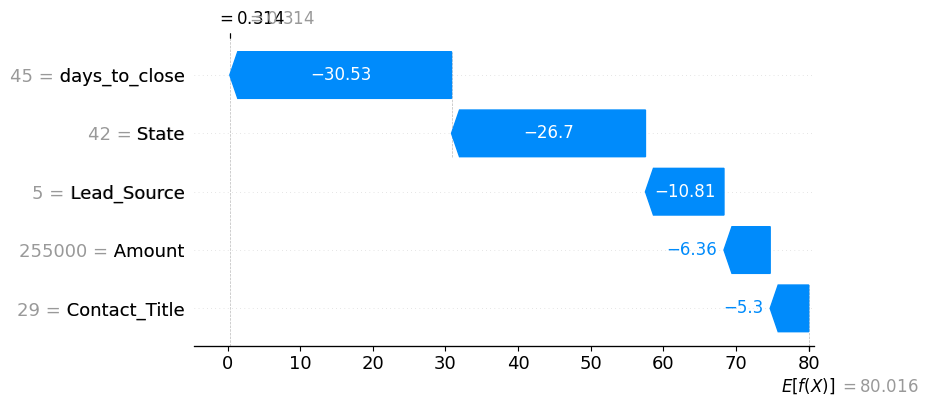

In [53]:
import shap 

explainer = shap.Explainer(xgb_model_train)
shap_values = explainer(X_train_new)
print(type(shap_values))
shap.plots.waterfall(shap_values[0])

In [54]:
print(shap_values)

.values =
array([[-6.3621230e+00, -5.3005586e+00, -1.0809880e+01, -2.6701548e+01,
        -3.0528004e+01],
       [-1.2378601e+00, -1.2065353e+00,  7.5098219e+00,  2.9608610e+00,
         1.2074818e+01],
       [-1.0716810e+00, -5.0180215e-01, -2.0597241e+00,  1.6814334e+00,
         2.1928312e+01],
       [-1.0720065e+00, -7.1847498e-01, -1.0091285e+00,  8.4615698e+00,
         1.4313898e+01],
       [-1.0374448e+00,  2.0183263e+00, -7.1127051e-01,  7.6121016e+00,
         1.2090928e+01],
       [-1.4545308e-01, -1.2260979e-02,  1.2793175e+01,  9.3391047e+00,
        -1.8318820e+00],
       [-3.4062083e+00,  1.1582904e+01, -1.7914888e+00, -9.2123842e+00,
         2.2693384e+01],
       [-1.5243989e+00, -1.3486794e+00, -1.0488164e+00,  7.5463300e+00,
         1.6366774e+01],
       [ 7.8478746e+00, -1.8036543e+00, -3.0911167e+00,  1.7415646e+01,
        -6.3531142e-01],
       [-2.4545305e+00,  1.3211146e+01, -3.4673288e+00,  1.6573172e+01,
        -4.0602355e+00],
       [ 5.8645692e+

In [55]:
import pandas as pd
importance_df = pd.DataFrame({
    "Feature": X_train_new.columns,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Mean SHAP Value", ascending=False)

print(importance_df)


         Feature  Mean SHAP Value
4  days_to_close        16.283821
2    Lead_Source         8.991290
3          State         8.254278
0         Amount         3.111083
1  Contact_Title         3.049456


### Export Feature Importance

In [56]:
# Create the folder if it doesn't exist
os.makedirs("2_2_salesforce_feature_importance_data", exist_ok=True)

# Save the Excel file inside the folder
importance_df.to_csv("2_2_salesforce_feature_importance_data/2_2_salesforce_feature_importance_data.csv", index=False)


In [57]:
# spark_df = spark.createDataFrame(importance_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.2_2_salesforce_feature_importance_data")